### Text Analytics Ref/Def Coursework - MSc in Big Data Analytics
#### July 2019

###### Name: A.B.Ameerdeen
###### IIT ID: 2018099
###### RGU ID: 1812896

### Answer (a)

Following are is the set of functions intended to be used throughout the notebook.

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jul  6 12:01:38 2019

@author: ammar
"""
import os as os
import pandas as pd
import re
import string
import nltk
from collections import Counter
from nltk.classify import NaiveBayesClassifier
import matplotlib.pyplot as plt
import numpy as np


# Use sklearn's metrics function for evaluation of classifiers
from sklearn import metrics

# Import the two classification algorithms we want to use for the task
# Based on the features we extract, we altogether have 6 combinations of models to train               
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

#for question C
# Extract features using the extractors we defined
#from feature_extractors import bow_extractor, tfidf_extractor
def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features
    
def tfidf_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

#from feature_extractors import averaged_word_vectorizer

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

#from feature_extractors import tfidf_weighted_averaged_word_vectorizer
def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors, 
                               tfidf_vocabulary, model, num_features):
                                   
    docs_tfidfs = [(doc, doc_tfidf) 
                   for doc, doc_tfidf 
                   in zip(corpus, tfidf_vectors)]
    features = [tfidf_wtd_avg_word_vectors(tokenized_sentence, tfidf, tfidf_vocabulary,
                                   model, num_features)
                    for tokenized_sentence, tfidf in docs_tfidfs]
    return np.array(features)


def question_c(my_dataset):
    train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(my_dataset, test_data_proportion=0.3)

    bow_vectorizer, bow_train_features = bow_extractor(tokens_to_sentences(train_corpus.Tokens) )  
    bow_test_features = bow_vectorizer.transform(tokens_to_sentences(test_corpus.Tokens) ) 

    mnb = MultinomialNB()

    mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,
                                               train_features=bow_train_features,
                                               train_labels=train_labels,
                                               test_features=bow_test_features,
                                               test_labels=test_labels)

    


def word2vec(my_dataset):
    train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(my_dataset, test_data_proportion=0.3)
    
    # First normalize both the training and test data using our previous funcionts                                                                        
    #from normalization import normalize_corpus
    
    norm_train_corpus =  train_corpus ;#normalize_corpus(train_corpus)
    norm_test_corpus = test_corpus ; #normalize_corpus(test_corpus)  
    
    ''.strip()
    
    # Extract features using the extractors we defined
    #bow features
    bow_vectorizer, bow_train_features = bow_extractor(norm_train_corpus.Phrase)  
    bow_test_features = bow_vectorizer.transform(norm_test_corpus.Phrase) 
    
    tokenized_train = norm_train_corpus.Tokens #[nltk.word_tokenize(text)                  for text in norm_train_corpus.Phrase]
    tokenized_test = norm_test_corpus.Tokens #[nltk.word_tokenize(text) for text in norm_test_corpus]  
    
    full_model = gensim.models.Word2Vec(tokenized_train,
                                   size=500,
                                   window=100,
                                   min_count=30,
                                   sample=1e-3)       
    mnb = MultinomialNB()
    print(full_model.wv.vocab);
    # Multinomial Naive Bayes with bag of words features
    mnb_bow_predictions_fulldataset = train_predict_evaluate_model(classifier=mnb,
                                               train_features=bow_train_features,
                                               train_labels=train_labels,
                                               test_features=bow_test_features,
                                               test_labels=test_labels) 

def generate_bow(tokenList):
    index = 0;
    print("Word List for Document \n{0} \n".format(tokenList));
    bow = []
    for tokens in tokenList:
        #bag_vector = np.zeros(len(tokens))
        
        c = Counter(tokens);
        #i = 0
        #for w in tokens:
               
         #   for sentence in tokenList:
             
                #for word in sentence:
                 #   if word == w:
                  #      print(word)
                   #     bag_vector[i] += 1
                        #print("{0}\n{1}\n".format(tokens,np.array(bag_vector)))
            #i = i +1
        bow.append(c)
    return bow
    


def load_stop_words():
    stop_data = pd.read_csv('stop_words.csv', encoding = 'utf-8') #,encoding = 'ISO-8859-1'
    stopwords = [];
    for index,row in stop_data.iterrows():
        stopwords.append(row[0])
    return stopwords;
        
#create a stemmer
def load_stem_dictionary():
    stem_data = pd.read_csv('sinhalese_stems.csv') #,encoding = 'ISO-8859-1'
    stems = pd.DataFrame(columns = ['Stem', 'Word'])
    dictionary = {};
    for index, row in stem_data.iterrows():
         s = re.split(r'\t+', row[0]);
         dictionary[s[0]]=s[1];
    return dictionary;

def word_feats(words, stopwords):
    return dict([(' '.join(word.split()), True) for word in words if ' '.join(word.split()) not in stopwords])


def non_stop_words(sentence_tokens):
    non_stop_tokens = [];
    for sentence in sentence_tokens:
        tokens = []
        token_dictionary = (word_feats(sentence,stopwords))
        for i in token_dictionary.keys():
            tokens.append(i)
        non_stop_tokens.append(tokens)
    return non_stop_tokens;

def extract_tokens(sentences):
    result = [];
    for sentence in sentences:
        sentence_tokens = [];
        s = sentence.replace('[\'','')
        s = s.replace('\']','')
        s = s.replace('\'','');
        for word in s.split(','):
            sentence_tokens.append(word)
        result.append(sentence_tokens)
    return result;

#stemming
def load_stem_df():
    stem_data = pd.read_csv('sinhalese_stems.csv')
    stems = pd.DataFrame(columns = ['Stem', 'Word'])
    
    word = [];
    stem = [];
    for index, row in stem_data.iterrows():
         s = re.split(r'\t+', row[0]);
         stem.append(s[1])
         word.append(s[0])
    stems.Stem = stem;
    stems.Word = word;
    return stems;
    
def get_number_of_tokens(sentences):
    length = 0;
    for words in sentences:
        unique_words = set(words)             # == set(['a', 'b', 'c'])
        unique_word_count = len(unique_words) # == 3
        length += unique_word_count
    return length

def get_max_sentence_length(sentences):
    initial_max_length = 0;
    for sentence in sentences:
        if (len(set(sentence)) > initial_max_length):
           initial_max_length= len(set(sentence))
    return initial_max_length;



#histograms
def show_token_histogram():    
    token_count = get_number_of_tokens(dataset.Tokens)
    stopwords_count = get_number_of_tokens(dataset.NonStop)
    stem_count = get_number_of_tokens(dataset.Stems)

    objects = ('Original', 'After removing Stop words', 'After Stemming')
    y_pos = np.arange(len(objects))
    performance = [token_count, stopwords_count, stem_count]
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Tokens')
    plt.title('Token reduction')
    
    plt.show()

def show_max_length_histogram():
    token_sentence_length = get_max_sentence_length(dataset.Tokens)
    stopwords_sentence_length = get_max_sentence_length(dataset.NonStop)
    stems_sentence_length = get_max_sentence_length(dataset.Stems)
    
    objects = ('Original', 'After removing Stop words', 'After Stemming')
    y_pos = np.arange(len(objects))
    performance = [token_sentence_length, stopwords_sentence_length, stems_sentence_length]
    
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Max Length')
    plt.title('Max length reduction')
    
    plt.show()



def get_stem(word):
    try:
        stem = stem_df[stem_df.Word == ' '.join(word.split())].Stem;
        if(len(stem) > 0):
            return stem.max()
        else:
            return word
        return 
    except Exception:
        return word


def stem_all(sentences):
    stem_sentences = [];
    cnt = 0;
    for sentence in sentences:
 #       print(sentence)
        cnt += 1;
        stems = []
        for word in sentence:
            i = get_stem(word)
            stems.append(i);
        stem_sentences.append(stems)
    return stem_sentences;

def get_columns(data):
    for col in data.columns: 
        print(col) 

# Divide the data into training and testing sets
def prepare_datasets(corpus, test_data_proportion=0.3):
    train, test = train_test_split(corpus, test_size=0.33, random_state=42)
    return train  , test, train.IsHateSpeech, test.IsHateSpeech

# We also remove empty documents since they would just add noise
def remove_empty_docs(corpus, labels):
    filtered_corpus = []
    filtered_labels = []
    for doc, label in zip(corpus, labels):
        if doc.strip():
            filtered_corpus.append(doc)
            filtered_labels.append(label)

    return filtered_corpus, filtered_labels
    


# Define function to calculate the 4 common mertics
def get_metrics(true_labels, predicted_labels):
    print('Given below are metrics for the model : ')
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        2))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))


# Master function to call the above defined functions to perform the classification,
# predict the results and evaluate predictions against the test data
def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels):
    # build model    
    model = classifier.fit(train_features, train_labels)
    #predict using model
    predictions = classifier.predict(test_features) 
    # evaluate model prediction performance   
    get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)
    return predictions   ,model



def is_ascii(s):
    return all(ord(c) < 128 for c in s)

def clean_ascii_sentence(phrase):
    phrase = str(phrase).lower()
    phrase = phrase.replace('<.*?>', '') #remove tags
    phrase = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",phrase).split())
    return phrase

def clean_unicode_sentence(phrase):
    phrase = str(phrase).lower()
    phrase = phrase.replace('<.*?>', '')
    return phrase
    
def seperate_and_clean_data(data):
    ascii_data = pd.DataFrame(columns = ['PhraseNo', 'Phrase' , 'IsHateSpeech' , "Tokens"])
    unicode_data = pd.DataFrame(columns = ['PhraseNo', 'Phrase' , 'IsHateSpeech' , "Tokens"]);

    ascii_Phrase = []    
    ascii_PhraseNo = []
    ascii_IsHateSpeech =  []
    ascii_Tokens = [];
    unicode_Phrase = []    
    unicode_PhraseNo = []
    unicode_IsHateSpeech =  []
    unicode_Tokens = []
    
    for row in data.iterrows():
        ascii_sentence = [];
        unicode_sentence = [];
        default_wt = nltk.word_tokenize
        tokens = default_wt(row[1].Phrase)
        for word in tokens:
            if(is_ascii(word)):
                    word = clean_ascii_sentence(word);
                    if( word != ''):
                        ascii_sentence.append(word)
            elif(word != ''):
                word = clean_unicode_sentence(word);
                unicode_sentence.append(word)
        if(len(ascii_sentence) > 0 ):
            ascii_Tokens.append(ascii_sentence)
            if(row[1].IsHateSpeech=='YES'):
                ascii_IsHateSpeech.append(1)
            else:
                ascii_IsHateSpeech.append(0)
            ascii_PhraseNo.append(row[1].PhraseNo)
            ascii_Phrase.append(tokens)
        if(len(unicode_sentence) > 0 ):
            unicode_Tokens.append(unicode_sentence)
            if(row[1].IsHateSpeech=='YES'):
                unicode_IsHateSpeech.append(1)
            else:
                unicode_IsHateSpeech.append(0)
            unicode_PhraseNo.append(row[1].PhraseNo)
            unicode_Phrase.append(tokens)
        
    ascii_data["Phrase"]=ascii_Phrase
    ascii_data["PhraseNo"]=ascii_PhraseNo
    ascii_data["IsHateSpeech"]=ascii_IsHateSpeech
    ascii_data["Tokens"]=ascii_Tokens
    
    unicode_data["Phrase"]=unicode_Phrase
    unicode_data["PhraseNo"]=unicode_PhraseNo
    unicode_data["IsHateSpeech"]=unicode_IsHateSpeech
    unicode_data["Tokens"]=unicode_Tokens
    
    return ascii_data, unicode_data;


def tokens_to_sentences(tokens):
    sentences = []
    for sent in tokens:
        unique_words = set(sent)
        sentences.append(" ".join(unique_words))
    return sentences


In [23]:
data=pd.read_csv('labelled_data.csv') #,encoding = 'ISO-8859-1'
ascii_dataset , unicode_dataset= seperate_and_clean_data(data)

ascii_dataset.to_csv('ascii_dataset.csv');
unicode_dataset.to_csv('unicode_dataset.csv')

print('Sinhalese sentence percentage : '+ str(100*(len(unicode_dataset)/len(data))))
print('Singlish sentence percentage : '+ str(100*(len(ascii_dataset)/len(data))))
print('Mixed percentage : ' + str(100- ((100*(len(ascii_dataset)/len(data))) + (100*(len(ascii_dataset)/len(data)))) ))

Sinhalese sentence percentage : 72.44
Singlish sentence percentage : 44.2
Mixed percentage : 11.599999999999994


Data is divided into singlish and sinhala datasets.

### Answer (b)

Text normalization happens below. We are basically removing stop words and stemming the corpus here. Then see how much we have cleaned the dataset using two diagrams.

C:\Users\ammar\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ammar\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()


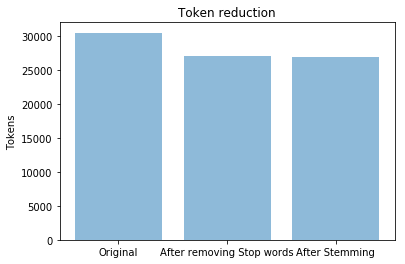

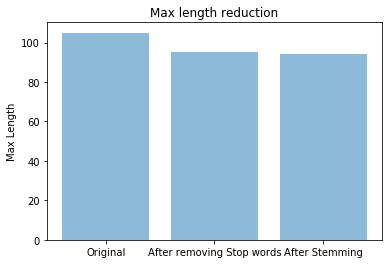

In [24]:

stem_dictionary = load_stem_dictionary()
stopwords = load_stop_words()
stem_df = load_stem_df()

dataset= unicode_dataset #pd.read_csv('sinhalese_data.csv') #,encoding = 'ISO-8859-1'

#stop word removal, stemming
#dataset.Tokens = extract_tokens(dataset.Tokens)
dataset.NonStop = non_stop_words(dataset.Tokens)
dataset.Stems = stem_all(dataset.NonStop)

dataset.to_csv('non_stop_stem_sinhalese.csv')

show_token_histogram()
show_max_length_histogram()

### Answer (c)

1) Corpus is split to training and test sets.

2). Bag of words vectorizer is created using CountVectorizer. 

3). Then the same function returns us the training feature vector.

4). Then we create a test feature vector.

5). We are using Multinomial Naive Bayes model.

6). Then we train the model using training vector and test the trained model using test feature vector.

In [25]:
train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(dataset, test_data_proportion=0.3)

bow_vectorizer, bow_train_features = bow_extractor(tokens_to_sentences(train_corpus.Tokens) )  
bow_test_features = bow_vectorizer.transform(tokens_to_sentences(test_corpus.Tokens) ) 

mnb = MultinomialNB()

mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,
                                           train_features=bow_train_features,
                                           train_labels=train_labels,
                                           test_features=bow_test_features,
                                           test_labels=test_labels)

Given below are metrics for the model : 
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1 Score: 0.72


### Answer (d)

Repeating the question c for given datasets.

In [26]:
full_dataset = pd.concat([unicode_dataset, ascii_dataset])
print('for the full dataset : ')
question_c(full_dataset) #fulll dataset 
print('\nfor the singlish dataset :')
question_c(ascii_dataset) # singlish dataset
print('\nfor the sinhalese dataset : ')
question_c(unicode_dataset) #sinhalese dataset

for the full dataset : 
Given below are metrics for the model : 
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
F1 Score: 0.69

for the singlish dataset :
Given below are metrics for the model : 
Accuracy: 0.67
Precision: 0.66
Recall: 0.67
F1 Score: 0.66

for the sinhalese dataset : 
Given below are metrics for the model : 
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1 Score: 0.72


What we can see according the the accuracy of these results is that models trained with the sinhala dataset predicts the result better than any other. The singlish dataset is performing lower than the remaining. But that could be due to data cleaning issues too. Anyhow, the difference between full dataset models and sinhala models is not that big either.

### Answer (e)



In [27]:
train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(dataset, test_data_proportion=0.2)

# TFIDF features
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(tokens_to_sentences(train_corpus.Tokens))  
tfidf_test_features = tfidf_vectorizer.transform(tokens_to_sentences(test_corpus.Tokens))    

model = gensim.models.Word2Vec(tokens_to_sentences(train_corpus.Tokens),
                               size=500,
                               window=100,
                               min_count=30,
                               sample=1e-3)      
vocab = tfidf_vectorizer.vocabulary_

mnb = MultinomialNB()
# Multinomial Naive Bayes with bag of words features
mnb_tfidf_predictions , model = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)



Given below are metrics for the model : 
Accuracy: 0.72
Precision: 0.73
Recall: 0.72
F1 Score: 0.71


Tfidf score based model is performing very similar to the Bag of Words based model.

### Answer (f)

In [28]:
train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(dataset, test_data_proportion=0.2)

# TFIDF features
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(tokens_to_sentences(train_corpus.Tokens) , ngram_range=(2,2))  
tfidf_test_features = tfidf_vectorizer.transform(tokens_to_sentences(test_corpus.Tokens))    


tokenized_train = train_corpus.Tokens #[nltk.word_tokenize(text)                  for text in norm_train_corpus.Phrase]
tokenized_test = test_corpus.Tokens #[nltk.word_tokenize(text) for text in norm_test_corpus]  

model = gensim.models.Word2Vec(tokenized_train,
                               size=500,
                               window=100,
                               min_count=30,
                               sample=1e-3)      

mnb = MultinomialNB()
# Multinomial Naive Bayes with bag of words features
mnb_tfidf_predictions , model = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)


Given below are metrics for the model : 
Accuracy: 0.61
Precision: 0.62
Recall: 0.61
F1 Score: 0.58


### Answer (g)

In [ ]:
The idea of overfitting is a model being too familiar to the testing data. To the point it predicts the training labels
tremendously well but failing sharp when it comes to the test set.